# WRUV Broadcasting Dataset Project
Authors: Sydney White and Zachary Hayes

In [5]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import time

## Data Collection, Cleaning, and Feature Engineering
#### Initial Collection and Cleaning


In [6]:
# Collect data CSVs into a single dataframe
dfs = []
directory = "dataset" 
for file in os.listdir(directory):
    df = pd.read_csv(f'{directory}/{file}')
    dfs.append(pd.read_csv(f'{directory}/{file}'))
df = pd.concat(dfs, axis=0)
df.sort_values("Date-time", inplace=True, ignore_index=True)
# Drop columns that we already know we don't need
df.drop(["Playlist Category", "DJ Email", "Date-time", "Composer"], axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df

PermissionError: [Errno 13] Permission denied: 'dataset/.ipynb_checkpoints'

In [ ]:
# Count null values
df.isna().sum()

In [3]:
# Clean the null values from the boolean columns New and Local
df["New"] = df["New"].map({"N": 1, np.nan: 0})
df["Local"] = df["Local"].map({"L": 1, np.nan: 0})

# Since there are only 56 instances where artist, song, or release are null,
# we feel comfortable dropping those instances
df = df.dropna(subset=["Artist", "Song", "Release"])

# Count null values again
df.isna().sum()


NameError: name 'df' is not defined

In [7]:
# Define smaller data set for linear regression (for now)
slices = []
# right now we have 2 slices, hopefully we will get a lot more 
for i in range(2):
    slices.append(pd.read_csv(f'slice{i}.csv'))
small = pd.concat(slices, axis=0)
small["Date"] = pd.to_datetime(small["Date"])
small

,Unnamed: 0,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,New,...,key,loudness,mode,speechiness,acousticness,instruemtnalness,liveness,valence,tempo,duration_ms
0,32428,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:00:43 AM,Darian Stavans,Ballad,Jazzy´Blue,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32429,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:03:25 AM,Mack Fields,I Like to Yodel,"Cults Hits Novelty Classics, Vol. 1",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32430,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:05:48 AM,Real Estate,Water Underground,Water Underground,0,...,0.664,-7.245,1.0,0.0314,0.0232,0.054200,0.133,0.919,111.907,206547.0
3,32431,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:09:14 AM,My Morning Jacket,Feelin Sorry,Feelin Sorry,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32432,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:12:02 AM,Joni Mitchell,A Case of You (feat. Marcus Mumford),A Case of You (feat. Marcus Mumford) (Live at ...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,37653,Unknown Summer,176422,DJ Desh,2024-01-17,8:02:56 AM,Björk,Alarm Call - Radio Mix,Alarm Call (Version 1),0,...,0.869,-5.785,0.0,0.0669,0.0450,0.000002,0.105,0.895,118.034,201600.0
2611,37654,Unknown Summer,176422,DJ Desh,2024-01-17,8:06:20 AM,Placid Angles,First Blue Sky,First Blue Sky,0,...,0.875,-5.455,0.0,0.0333,0.0283,0.908000,0.114,0.873,144.999,309023.0
2612,37655,Unknown Summer,176422,DJ Desh,2024-01-17,8:09:39 AM,Tirzah,No Romance,No Romance,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2613,37656,Unknown Summer,176422,DJ Desh,2024-01-17,8:13:21 AM,Burial,Claustro,Claustro / State Forest,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Additional Collection: Filling Missing Genres and Spotify Audio Features

In [9]:
# global variable for valid genres in spinitron 
GENRES = small['Genre'].unique().tolist()
for g in range(len(GENRES)):
    GENRES[g] = (str(GENRES[g])).lower()
    
# function to interface with Spotify Web API app (created with id and secret below) STILL WIP!
def spotify_connect():
    # technically insecure to have client secret displayed like this (environment variable)
    CLIENT_ID = '344d3b062e344710a5bdb8427358a31d'
    CLIENT_SECRET = '9f886dde51184f989b1aff4f5ffb21f8'
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    auth_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        requests_session=True)

    sp = spotipy.Spotify(auth_manager=auth_manager)
    # this is our connection which we will need for any future query 
    return sp
    
# just making this global for effeciency (no need to reaccess every time) 
sp = spotify_connect()

def get_genre_by_artist(artist_name):
    # spotify queries are all based on Spotify URI IDs and usually return in JSON
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=10)
    except TypeError:
        print(artist_name + "unable to search")
        return 'NA'
    # make sure that the result is for the artist we want
    try: 
        result_name = results['artists']['items'][0]['name']
    except IndexError:
        result_name = ''
        return 'NA'
    i = 0
    while (result_name != artist_name) & (i < 10) & (i < len(results)):
        result_name = results['artists']['items'][i]['name']
        i += 1
    if (result_name == artist_name):
        genres = results['artists']['items'][i]['genres'] # for top result (in this case accurate, but probably not always)
        id = results['artists']['items'][i]['id']
        for genre in genres:
            if genre in GENRES:
                return genre 
    return 'NA'

print(len(small))
print(small["Genre"].isna().sum())

small.loc[small["Genre"].isna(), "Genre"] = small.loc[small["Genre"].isna()].apply(get_genre_by_artist)
#lr.loc[lr["Genre"].isna(), "Genre"] = lr.loc[lr["Genre"].isna()].apply(get_genre_by_artist)

print(small["Genre"].isna().sum())
#lr["Genre"] = lr["Genre"].astype('str')
#print((lr["Genre"].iloc[5]))

#df.loc[df['area'].isna(), 'Area'] = df.loc[df['area'].isna()].apply(lambda x: sample_func(x['Val']), axis = 1)

#smaller['Genre'] = df['Artist'].apply(lambda x: get_genre_by_artist(x) if pd.isnull(df['Genre']) else x)
#smaller['songAudio'] = smaller.apply(lambda row: spotify_search_song(row['Artist'], row['Song']), axis=1)
#lr["Genre"].isna()
#smaller

5230
2190


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U16')) -> None

In [ ]:
#### Feature Engineering: Checking Billboard Charts for Specific Songs 

In [7]:
print(df["Genre"].isna().sum())
print(df["Genre"].describe())

97305
count     187382
unique        20
top         Rock
freq       61335
Name: Genre, dtype: object


'\nfor r in range(len(df)):\n    if df.loc[r]["Genre"] == "nan":\n        df.loc[r]["Genre"] = get_genre_by_artists(token, df.loc[r]["Artist"])\n        print(df.loc[r]["Artist"], df.loc[r]["Genre"])\nprint(\'done\')\nprint(df["Genre"].isna().sum())\n'

#### Data Wrangling and Visualization

<BarContainer object of 20 artists>

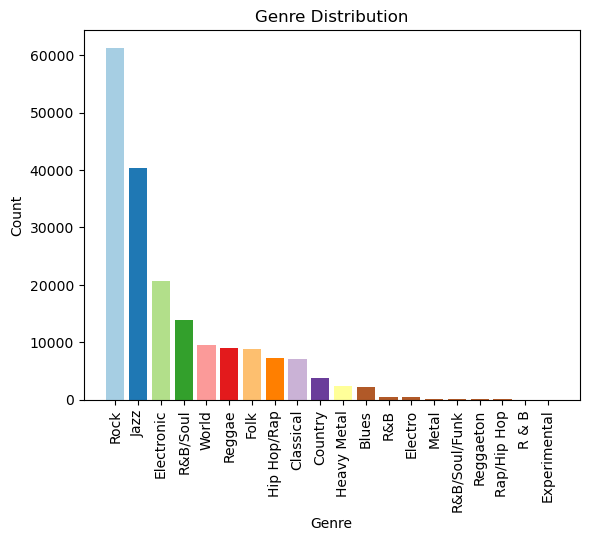

In [8]:
# Visualize genre distribution
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))

# TODO: Combine genres


<Axes: >

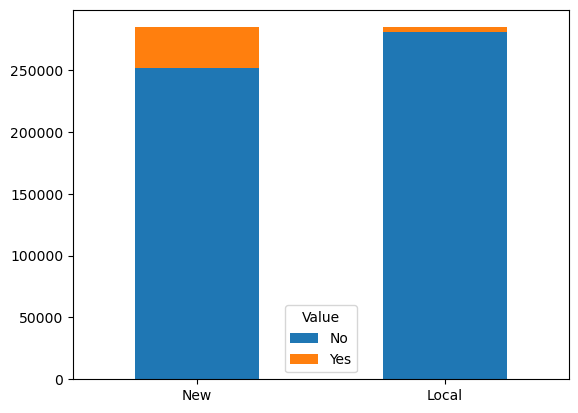

In [9]:
# Visualize local and new distributions
total_spins = df.shape[0]
num_new = df["New"].sum()
num_local = df["Local"].sum()
new_and_local = pd.DataFrame({"New": [total_spins - num_new, num_new],
                              "Local": [total_spins - num_local, num_local],
                              "Value": ["No", "Yes"]}).set_index("Value")
new_and_local.T.plot.bar(stacked=True, rot=0)
    

In [13]:
# Temporary add (for work below), until the feature is properly created via scraping
df["Top100"] = np.random.randint(1, 6, df.shape[0])

C:\Users\16107\AppData\Local\Temp\ipykernel_34356\4287299848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Top100"] = np.random.randint(1, 6, df.shape[0])


In [14]:
def spins_to_dj(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    # Engineered Features: avg time of day (start time), avg duration, average # spins
    eng_df = spin_df[["DJ Name", "Playlist Title", "Playlist Duration", "Date", "Time"]]

    pattern = "%I:%M:%S %p"
    def to_min(x):
        time_extracted = datetime.strptime(x, pattern)
        return time_extracted.hour*60 + time_extracted.minute
    eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))
    start_times_df = eng_df.groupby(["DJ Name", "Date"]).min().reset_index()
    dj_df["Avg_Start"] = start_times_df[["DJ Name", "Time"]].groupby("DJ Name").mean().reset_index()["Time"]

    duration_df = eng_df[["DJ Name", "Playlist Duration"]]
    dj_df["Avg_Duration"] = duration_df.groupby("DJ Name").mean().reset_index()["Playlist Duration"]

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    avg_spin_df = one_day_spin_count_df[["DJ Name", "Playlist Title"]].groupby("DJ Name").mean().reset_index()
    dj_df["Avg_Spins"] = avg_spin_df["Playlist Title"]

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')

    # Count popular artist policy violations
    dj_df["top_violations"] = spin_df[["DJ Name", "Top100"]].groupby(["DJ Name"]).sum().reset_index()["Top100"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["top_violations"]
    #dj_df = dj_df.drop(columns=["new_violations", "top_violations"])

    return dj_df

df1 = spins_to_dj(spin_df=df)
df1

C:\Users\16107\AppData\Local\Temp\ipykernel_34356\351962934.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))


,DJ Name,Total_Spins,Avg_Start,Avg_Duration,Avg_Spins,Blues,Classical,Country,Electro,Electronic,...,R&B/Soul,R&B/Soul/Funk,Rap/Hip Hop,Reggae,Reggaeton,Rock,World,new_violations,top_violations,Violations
0,Adam Higgins,1270,15.000000,129.448819,26.458333,2.0,319.0,2.0,0.0,620.0,...,77.0,0.0,0.0,0.0,0.0,42.0,6.0,3,3843,3846
1,Agent One,402,575.791667,81.343284,16.750000,0.0,0.0,3.0,0.0,10.0,...,10.0,0.0,0.0,0.0,0.0,250.0,5.0,12,1211,1223
2,Ava P,1676,960.160000,122.398568,33.520000,8.0,1.0,11.0,1.0,45.0,...,14.0,0.0,0.0,5.0,0.0,644.0,12.0,50,4962,5012
3,B. Stokes,621,948.526316,120.000000,32.684211,2.0,0.0,243.0,0.0,1.0,...,6.0,0.0,0.0,3.0,0.0,94.0,52.0,19,1862,1881
4,Babytooth,321,4.666667,163.551402,35.666667,0.0,1.0,1.0,1.0,27.0,...,8.0,0.0,0.0,3.0,0.0,66.0,3.0,6,955,961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,lizard,640,944.181818,106.406250,19.393939,1.0,2.0,6.0,1.0,19.0,...,27.0,0.0,0.0,7.0,0.0,160.0,8.0,33,1934,1967
238,old greg,14,662.000000,60.000000,14.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1,48,49
239,otis cleveland,3866,1188.071856,127.853078,23.149701,153.0,204.0,86.0,2.0,98.0,...,126.0,0.0,0.0,27.0,0.0,469.0,346.0,150,11736,11886
240,syd,269,739.111111,120.000000,29.888889,1.0,0.0,0.0,0.0,16.0,...,66.0,0.0,0.0,0.0,0.0,135.0,2.0,4,812,816


In [48]:
def spins_to_shows(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in spin format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    #dj_df["Total Spins"] = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    #dj_df = dj_df[["DJ Name", "Date", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
        
    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title", "Date"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations", "show_spins"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')

    # Count popular artist policy violations
    dj_df["artist_bb"] = spin_df[["DJ Name", "artistBB"]].groupby(["DJ Name"]).sum().reset_index()["artistBB"]
    dj_df["artist_violations"] = dj_df["artist_bb"] / dj_df["show_spins"]
    
    #dj_df["artist_violation_B"] = dj_df[dj_df["artist_violations" > 0.2]]

    dj_df["song_violations"] = spin_df[["DJ Name", "songBB"]].groupby(["DJ Name"]).sum().reset_index()["songBB"]
    #dj_df = dj_df.drop(columns=["Unnamed:0", "Playlist Title", "DJ ID", "Song", "Release", "New"])

    # Calculate policy violation feature
    #dj_df["Violations"] = dj_df["new_violations"] + dj_df["top_violations"]
    #dj_df = dj_df.drop(columns=["new_violations", "top_violations"])

    return dj_df

#spin_df = small
small_djs = spins_to_shows(spin_df=small)
small_djs
list(small
#small_djs = small.groupby(["DJ Name", "Date"])
#small_djs.first()

KeyError: "['Unnamed:0'] not found in axis"

## Data Modeling

#### Policy Violation Linear Regression

#### DJ Clustering